데이터 분석 절차

1. 기획 (주가 예측 -어떤걸? )
2. 데이터 수집 (크롤링, 라이브러리, 다운로드, API)
3. 데이터 EDA, 전처리(가공)
4. 모델링 (어떤 모델을 사용할 것인지 - 데이터 셋을 보고, 머신 vs. 딥, 분류 vs. 회귀)
5. 학습
6. 평가 (테스트)

In [2]:
pip install -U finance-datareader

In [2]:
import FinanceDataReader as fdr

In [3]:
fdr.StockListing('KRX')
df_samsung=fdr.DataReader('005930','2017-01-01','2020-12-31')

In [68]:
from sklearn.preprocessing import RobustScaler
data= RobustScaler(quantile_range=(-1,1)).fit_transform(df_samsung['Close'].to_numpy().reshape(-1, 1))

In [69]:
data

array([[-1.53896104e+00],
       [-1.48961039e+00],
       [-1.53116883e+00],
       [-1.60909091e+00],
       [-1.52597403e+00],
       [-1.39350649e+00],
       [-1.39090909e+00],
       [-1.25584416e+00],
       [-1.18831169e+00],
       [-1.36233766e+00],
       [-1.46623377e+00],
       [-1.42727273e+00],
       [-1.42987013e+00],
       [-1.35974026e+00],
       [-1.39610390e+00],
       [-1.28441558e+00],
       [-1.27142857e+00],
       [-1.11038961e+00],
       [-1.04545455e+00],
       [-1.10259740e+00],
       [-1.14675325e+00],
       [-1.11558442e+00],
       [-1.10259740e+00],
       [-1.08961039e+00],
       [-1.18571429e+00],
       [-1.24025974e+00],
       [-1.24025974e+00],
       [-1.24545455e+00],
       [-1.29740260e+00],
       [-1.34675325e+00],
       [-1.32857143e+00],
       [-1.28961039e+00],
       [-1.31038961e+00],
       [-1.20649351e+00],
       [-1.17012987e+00],
       [-1.12337662e+00],
       [-1.13896104e+00],
       [-1.26363636e+00],
       [-1.2

In [70]:
import torch
print(torch.__version__)

2.0.1+cu118


In [71]:
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm

In [72]:
data.shape

(981, 1)

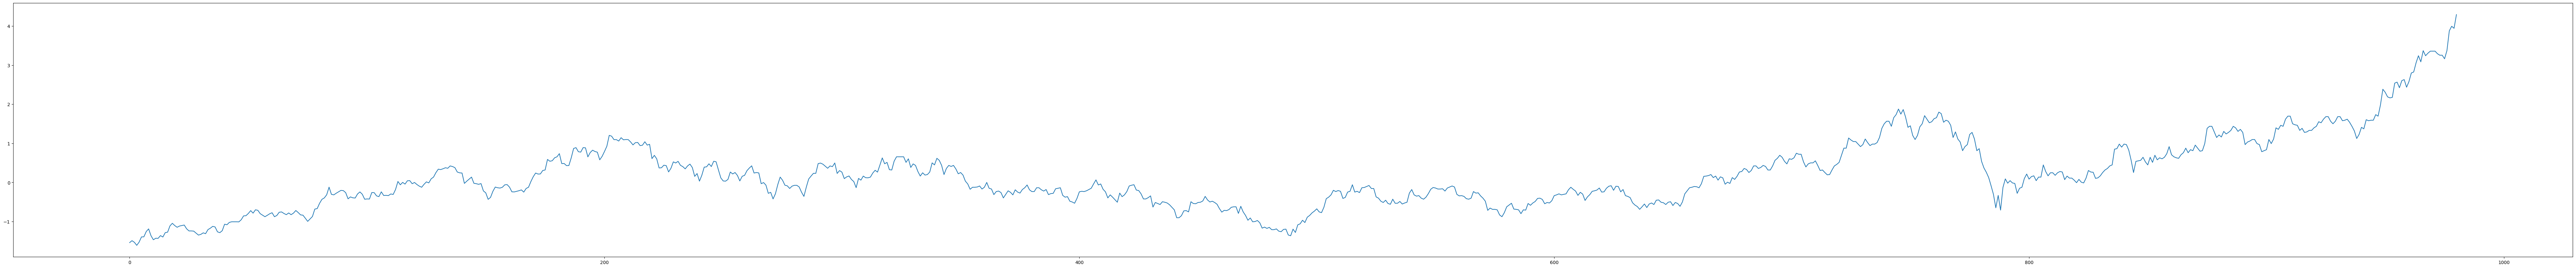

In [73]:
plt.figure(figsize=[100, 10])
plt.plot(np.arange(0, 981), data)
plt.show()

In [77]:
x_sin = np.array([[data[i+j] for j in range(7)] for i in range(len(data)-7)])
y_sin = np.array([data[i+7] for i in range(len(data)-7)])
x_sin.shape, y_sin.shape

((974, 7, 1), (974, 1))

In [78]:
train_idx = int(len(x_sin) * 0.7) # 70% 데이터까지의 인덱스

X_train = x_sin[:train_idx]
y_train = y_sin[:train_idx]
X_test = x_sin[train_idx:]
y_test = y_sin[train_idx:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(681, 7, 1) (293, 7, 1)
(681, 1) (293, 1)


In [79]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x.reshape(-1, 7, 1))
        self.y = torch.Tensor(y)

    def __getitem__(self, idx):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [80]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [81]:
class SamsungLSTM(nn.Module):
    def __init__(self):
        super(SamsungLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=7, num_layers=1, batch_first=True)
        self.fc = nn.Linear(7, 1)
        return

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])

        return output

In [147]:
model = SamsungLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.25)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [148]:
epochs = 50

for epoch in range(1, epochs+1):
    train_loss = []
    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.15071] Val Loss : [0.75220]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.01589] Val Loss : [0.34367]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.01009] Val Loss : [0.30845]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00952] Val Loss : [0.30474]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00988] Val Loss : [0.33227]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00951] Val Loss : [0.31777]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00945] Val Loss : [0.29939]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00913] Val Loss : [0.31194]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00929] Val Loss : [0.30712]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00908] Val Loss : [0.30639]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.00927] Val Loss : [0.30864]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00915] Val Loss : [0.30633]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.00920] Val Loss : [0.30811]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.00909] Val Loss : [0.30744]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.00898] Val Loss : [0.30681]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00892] Val Loss : [0.30826]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00899] Val Loss : [0.30761]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00904] Val Loss : [0.30720]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00934] Val Loss : [0.30753]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00898] Val Loss : [0.30816]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00888] Val Loss : [0.30838]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.00886] Val Loss : [0.30830]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00883] Val Loss : [0.30831]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00896] Val Loss : [0.30827]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00887] Val Loss : [0.30826]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00887] Val Loss : [0.30822]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00898] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00892] Val Loss : [0.30825]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.00911] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00896] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.00899] Val Loss : [0.30825]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.00903] Val Loss : [0.30825]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.00930] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.00911] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.00898] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.00910] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.00911] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.00937] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.00907] Val Loss : [0.30825]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.00900] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.00902] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.00906] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.00890] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.00908] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.00952] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.00899] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.00905] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.00916] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.00916] Val Loss : [0.30824]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.00888] Val Loss : [0.30824]


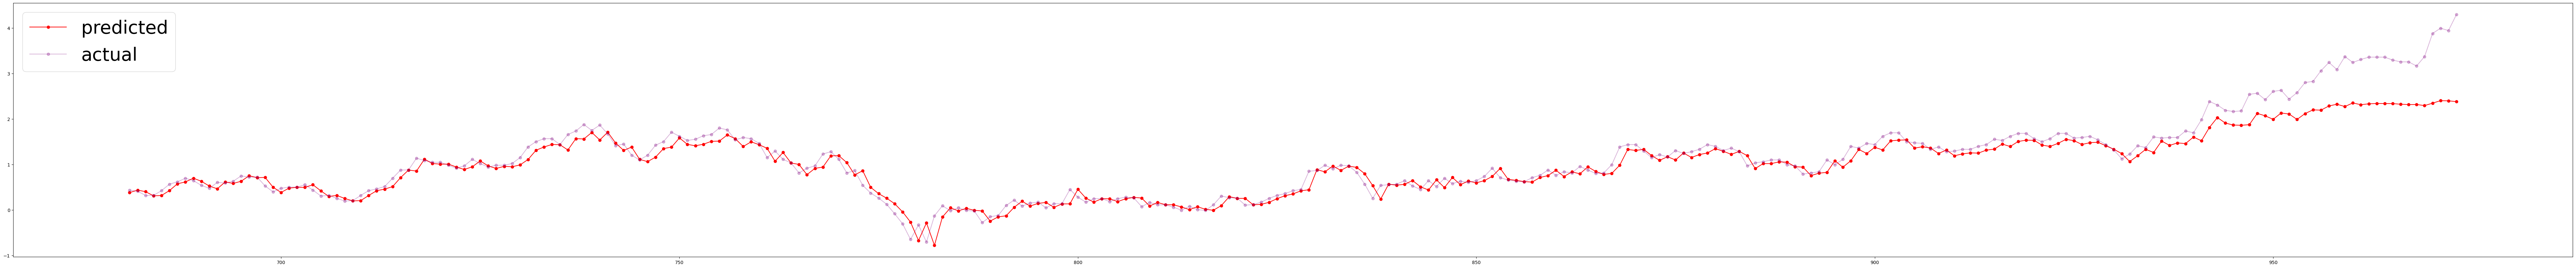

In [149]:
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()